# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Window

from pyspark.sql.functions import *
from pyspark.sql.types import *

import numpy as np
import pandas as pd
import datetime
from time import time
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, VectorAssembler, MinMaxScaler
from pyspark.ml.classification import (NaiveBayes, LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, LinearSVC)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

%matplotlib inline

In [2]:
# Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

In [3]:
# checking the Spark session
spark.sparkContext.getConf().getAll()
spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
# define path and load json file as dataframe
path = "mini_sparkify_event_data.json"
df = spark.read.json(path)

# check dataframe structure
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



#### 18 columns in total, 12 strings and 6 numerical

In [5]:
df.toPandas().shape

(286500, 18)

In [6]:
# checking how data looks
df.toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [7]:
df.describe(['artist']).show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+



Random characters appear for artist 

In [8]:
df.groupBy('auth').count().sort(desc('count')).show()

+----------+------+
|      auth| count|
+----------+------+
| Logged In|278102|
|Logged Out|  8249|
|     Guest|    97|
| Cancelled|    52|
+----------+------+



In [9]:
df.groupBy('gender').count().sort(desc('count')).show()

+------+------+
|gender| count|
+------+------+
|     F|154578|
|     M|123576|
|  null|  8346|
+------+------+



In [10]:
df.groupBy('level').count().sort(desc('count')).show()

+-----+------+
|level| count|
+-----+------+
| paid|228162|
| free| 58338|
+-----+------+



In [11]:
df.describe(['method', 'page', 'registration', 'sessionId']).show()

+-------+------+-------+--------------------+-----------------+
|summary|method|   page|        registration|        sessionId|
+-------+------+-------+--------------------+-----------------+
|  count|286500| 286500|              278154|           286500|
|   mean|  null|   null|1.535358834084427...|1041.526554973822|
| stddev|  null|   null| 3.291321616327586E9|726.7762634630741|
|    min|   GET|  About|       1521380675000|                1|
|    max|   PUT|Upgrade|       1543247354000|             2474|
+-------+------+-------+--------------------+-----------------+



In [12]:
df.groupBy('method').count().sort(desc('count')).show()

+------+------+
|method| count|
+------+------+
|   PUT|261064|
|   GET| 25436|
+------+------+



In [13]:
df.groupBy('page').count().sort(desc('count')).show(30, truncate=False)

+-------------------------+------+
|page                     |count |
+-------------------------+------+
|NextSong                 |228108|
|Home                     |14457 |
|Thumbs Up                |12551 |
|Add to Playlist          |6526  |
|Add Friend               |4277  |
|Roll Advert              |3933  |
|Login                    |3241  |
|Logout                   |3226  |
|Thumbs Down              |2546  |
|Downgrade                |2055  |
|Help                     |1726  |
|Settings                 |1514  |
|About                    |924   |
|Upgrade                  |499   |
|Save Settings            |310   |
|Error                    |258   |
|Submit Upgrade           |159   |
|Submit Downgrade         |63    |
|Cancel                   |52    |
|Cancellation Confirmation|52    |
|Register                 |18    |
|Submit Registration      |5     |
+-------------------------+------+



In [14]:
df.describe(['song']).show()

+-------+--------------------+
|summary|                song|
+-------+--------------------+
|  count|              228108|
|   mean|            Infinity|
| stddev|                 NaN|
|    min|ÃÂg ÃÂtti Gr...|
|    max|ÃÂau hafa slopp...|
+-------+--------------------+



Random characters appear for song as well

In [15]:
df.describe(['status', 'ts', 'userAgent', 'userId']).show()

+-------+------------------+--------------------+--------------------+-----------------+
|summary|            status|                  ts|           userAgent|           userId|
+-------+------------------+--------------------+--------------------+-----------------+
|  count|            286500|              286500|              278154|           286500|
|   mean|210.05459685863875|1.540956889810483...|                null|59682.02278593872|
| stddev| 31.50507848842214|1.5075439608226302E9|                null|109091.9499991047|
|    min|               200|       1538352117000|"Mozilla/5.0 (Mac...|                 |
|    max|               404|       1543799476000|Mozilla/5.0 (comp...|               99|
+-------+------------------+--------------------+--------------------+-----------------+



userId has blanks appearing

In [16]:
df.groupBy('status').count().show()

+------+------+
|status| count|
+------+------+
|   307| 26430|
|   404|   258|
|   200|259812|
+------+------+



In [17]:
# find NaNs and Nulls in dataframe

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



artist, length, song have the same number of missing cases (58392) - probably data relates to the same instance

firstName, gender, lastName, location, registration, userAgent have the same number of missing cases (8346) - indicating that there is no information present for these cases

In [18]:
# find empty strings in dataframe
df.select([count(when(col(c) == '', c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|  8346|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



only userId contains empty strings, and the number of missing cases is the same as above (8346)

In [19]:
# print distinct values for column 'auth' where 'userId' is empty
df.select('auth').where(col('userId') == '').groupBy('auth').count().show()

+----------+-----+
|      auth|count|
+----------+-----+
|Logged Out| 8249|
|     Guest|   97|
+----------+-----+



where userId is blank, the auth column has values Logged Out and Guest, which is the reason why the values are missing.  Those records are deleted below

In [20]:
# drop rows with no user data (Logged Out or Guest)
df_clean = df.where(col('userId') != '')

In [21]:
# check NaNs and Nulls in new dataframe
df_clean.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_clean.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [22]:
# udf to convert timestamp to correct format

get_timestamp = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).strftime('%Y-%m-%d %H:%M:%S'))

# apply udf to registration timestamp
df_clean = df_clean.withColumn('registration', get_timestamp(df_clean['registration']))

# apply udf to ts timestamp
df_clean = df_clean.withColumn('ts', get_timestamp(df_clean['ts']))

In [23]:
df_clean.select('registration').show()

+-------------------+
|       registration|
+-------------------+
|2018-09-28 22:22:42|
|2018-09-30 18:20:30|
|2018-09-28 22:22:42|
|2018-09-30 18:20:30|
|2018-09-28 22:22:42|
|2018-09-30 18:20:30|
|2018-09-30 18:20:30|
|2018-09-28 22:22:42|
|2018-09-28 22:22:42|
|2018-09-28 22:22:42|
|2018-09-30 18:20:30|
|2018-09-30 18:20:30|
|2018-09-28 22:22:42|
|2018-09-30 18:20:30|
|2018-09-30 18:20:30|
|2018-09-28 22:22:42|
|2018-09-30 18:20:30|
|2018-09-19 13:53:39|
|2018-09-28 22:22:42|
|2018-09-30 18:20:30|
+-------------------+
only showing top 20 rows



In [24]:
# time period for all events in dataset
df_clean.groupBy(year('ts'), month('ts')).count().sort(month('ts')).show()

+--------+---------+------+
|year(ts)|month(ts)| count|
+--------+---------+------+
|    2018|       10|144916|
|    2018|       11|133234|
|    2018|       12|     4|
+--------+---------+------+



In [25]:
# split location column into two, one column with location name and one column with the state
df_clean = df_clean.withColumn('location_name', split(col('location'), ',').getItem(0))
df_clean = df_clean.withColumn('state', split(col('location'), ',').getItem(1))
# keep only the first state
df_clean = df_clean.withColumn('state', split(col('state'), '-').getItem(0))

In [26]:
df_clean.select('location_name').show(truncate=False)

+-----------------------+
|location_name          |
+-----------------------+
|Bakersfield            |
|Boston-Cambridge-Newton|
|Bakersfield            |
|Boston-Cambridge-Newton|
|Bakersfield            |
|Boston-Cambridge-Newton|
|Boston-Cambridge-Newton|
|Bakersfield            |
|Bakersfield            |
|Bakersfield            |
|Boston-Cambridge-Newton|
|Boston-Cambridge-Newton|
|Bakersfield            |
|Boston-Cambridge-Newton|
|Boston-Cambridge-Newton|
|Bakersfield            |
|Boston-Cambridge-Newton|
|Tallahassee            |
|Bakersfield            |
|Boston-Cambridge-Newton|
+-----------------------+
only showing top 20 rows



In [27]:
df_clean.select('state').show()

+-----+
|state|
+-----+
|   CA|
|   MA|
|   CA|
|   MA|
|   CA|
|   MA|
|   MA|
|   CA|
|   CA|
|   CA|
|   MA|
|   MA|
|   CA|
|   MA|
|   MA|
|   CA|
|   MA|
|   FL|
|   CA|
|   MA|
+-----+
only showing top 20 rows



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [28]:
# create new column 'churn'
# churn = 1 (yes) if column page = 'Cancellation Confirmation', else 0 (No)
df_clean = df_clean.withColumn('churn', when(col('page') == 'Cancellation Confirmation', 1).otherwise(0))

# Show counts per value for 'churn'
df_clean.groupBy('churn').count().show()

+-----+------+
|churn| count|
+-----+------+
|    1|    52|
|    0|278102|
+-----+------+



In [29]:
## churn, where a user is considered to have churned only when they have deleted their account and completely stopped using the service. This is easily accessed in the data as 'page == Cancellation Confirmation' and applies to both free and paid plans the same way.

# get userId's where churn = 1
churned_users = df_clean.select('userId').where(col('churn') == 1).groupby('userId').count()

# only keep values from 'userId' column and store as list

churned_users = [row['userId'] for row in churned_users.collect()]

# print userId's for churned users
churned_users

['125',
 '51',
 '54',
 '100014',
 '101',
 '29',
 '100021',
 '87',
 '73',
 '3',
 '28',
 '100022',
 '100025',
 '300007',
 '100006',
 '18',
 '70',
 '100005',
 '17',
 '100007',
 '300001',
 '100009',
 '100015',
 '200024',
 '100003',
 '103',
 '100024',
 '53',
 '122',
 '200017',
 '58',
 '100011',
 '100019',
 '100012',
 '200018',
 '200016',
 '200020',
 '106',
 '143',
 '32',
 '200001',
 '105',
 '200011',
 '100023',
 '100013',
 '100017',
 '121',
 '12',
 '200015',
 '129',
 '200021',
 '100001']

In [30]:
# set column 'churn' as 1 for all rows for a churned user
df_clean = df_clean.withColumn('churn', when((df_clean.userId).isin(churned_users), 1).otherwise(0))

# Show counts per value for 'churn'
df_clean.groupBy('churn').count().show()

+-----+------+
|churn| count|
+-----+------+
|    1| 44864|
|    0|233290|
+-----+------+



In [31]:
# show all events related to a churned user
df_clean.select(['itemInSession', 'level', 'method', 'page', 'sessionId', 'ts', 'userId', 'churn']).where(col('userId') == 100014).toPandas()

,itemInSession,level,method,page,sessionId,ts,userId,churn
0,0,paid,PUT,NextSong,37,2018-10-10 13:12:16,100014,1
1,1,paid,PUT,NextSong,37,2018-10-10 13:15:51,100014,1
2,2,paid,PUT,NextSong,37,2018-10-10 13:17:56,100014,1
3,3,paid,PUT,NextSong,37,2018-10-10 13:21:38,100014,1
4,4,paid,GET,Help,37,2018-10-10 13:21:45,100014,1
5,5,paid,PUT,NextSong,37,2018-10-10 13:25:56,100014,1
6,6,paid,PUT,NextSong,37,2018-10-10 13:36:51,100014,1
7,7,paid,PUT,NextSong,37,2018-10-10 13:41:54,100014,1
8,8,paid,PUT,NextSong,37,2018-10-10 13:45:53,100014,1
9,9,paid,PUT,NextSong,37,2018-10-10 13:51:50,100014,1


In [32]:
# number of rows/events in dataframe
print('Number of events (rows) in dataset: {}'.format(df_clean.count()))

# number of unique userId's in dataframe
print('Number of unique users: {}'.format(df_clean.select('userId').distinct().count()))

# number of users that have churned
print('Number of users that have churned: {}'.format(
df_clean.where(col('churn') == 1).groupBy('userId').count().count()))

# number of active users (not churned)
print('Number of active users (not churned): {}'.format(
df_clean.where(col('churn') == 0).groupBy('userId').count().count()))

Number of events (rows) in dataset: 278154
Number of unique users: 225
Number of users that have churned: 52
Number of active users (not churned): 173


There are three-times more active users than churned users

In [33]:
# convert dataframe to pandas dataframe
df_clean_pd = df_clean.toPandas()

# create filter with rows that have the value 'Cancel' in column 'page'
filter = df_clean_pd.loc[df_clean_pd['page'] == 'Cancel'].index

# use filter to select rows before rows in filter to see what user did before the event 'Cancel'
df_clean_pd.iloc[filter-1].page.value_counts(ascending=False)

Downgrade      19
Settings       14
Roll Advert    14
Thumbs Down     4
Add Friend      1
Name: page, dtype: int64

Amongst churned customers, Downgrade page was the most vistited followed by Settings page.  Interestingly, an equal number of customers saw that advert, which probably triggered them to go to the Settings page. 

In [34]:
# before cancelling
ts_cancel = pd.to_datetime(df_clean_pd.loc[df_clean_pd['page'] == 'Cancel'].ts.values)
ts_before_cancel = pd.to_datetime(df_clean_pd.iloc[filter-1].ts.values)

# create pandas series with the time difference between cancelling and the last event before cancelling
ts_diff = pd.Series(ts_cancel - ts_before_cancel)
# average time differene between cancelling and the last event before cancelling
ts_diff.mean()

Timedelta('0 days 00:00:01')

There is no time lag between cancelling their subscription and the previous step indicating that cancelling subscription was an instantenous decision 

In [35]:
print('Average number of interactions (events) for churned users: {:.0f}'.format(
    df_clean.where(col('churn') == 1).count() / 
    df_clean.where(col('churn') == 1).groupBy('userId').count().count()))

print('Average number of interactions (events) for active users: {:.0f}'.format(
    df_clean.where(col('churn') == 0).count() / 
    df_clean.where(col('churn') == 0).groupBy('userId').count().count()))

print('')

# average number of sessions per user
print('Average number of sessions for churned users: {:.0f}'.format(
    df_clean.where(col('churn') == 1).groupBy('userId', 'sessionId').count().count() / 
    df_clean.where(col('churn') == 1).groupBy('userId').count().count()))

print('Average number of sessions for active users: {:.0f}'.format(
    df_clean.where(col('churn') == 0).groupBy('userId', 'sessionId').count().count() / 
    df_clean.where(col('churn') == 0).groupBy('userId').count().count()))

print('')

# average number of items in a session per user
print('Average number of items in a session for churned users: {:.0f}'.format(
    df_clean.where(col('churn') == 1).count() / 
    df_clean.where(col('churn') == 1).groupBy('userId', 'sessionId').count().count()))

print('Average number of items in a session for active users: {:.0f}'.format(
    df_clean.where(col('churn') == 0).count() / 
    df_clean.where(col('churn') == 0).groupBy('userId', 'sessionId').count().count()))

Average number of interactions (events) for churned users: 863
Average number of interactions (events) for active users: 1348

Average number of sessions for churned users: 10
Average number of sessions for active users: 15

Average number of items in a session for churned users: 84
Average number of items in a session for active users: 88


Active users have higher average number of interactions, average number of sessions, and average number of items

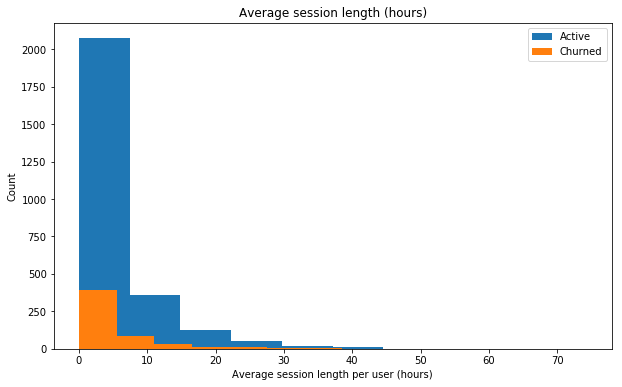


Average session length for churned users (hours):
+-------------------+
|avg(session_length)|
+-------------------+
|  4.718692338992486|
+-------------------+

Average session length for active users (hours):
+-------------------+
|avg(session_length)|
+-------------------+
|  5.047589365434434|
+-------------------+



In [39]:
# average session length per user
# udf to convert time to correct format and show time difference in hours
# source: https://stackoverflow.com/questions/30283415/calculating-duration-by-subtracting-two-datetime-columns-in-string-format
time_delta = udf(lambda y, x: (datetime.datetime.strptime(y, '%Y-%m-%d %H:%M:%S') - 
                               datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')).total_seconds()/3600)

# create dataframe with first timestamp (ts) per session
# add column 'churn' and set as 1 for rows with churned user
df_min = df_clean.groupBy('userId', 'sessionId').agg(min('ts').alias('min_ts'))
df_min = df_min.withColumn('churn', when((df_min.userId).isin(churned_users), 1).otherwise(0))

# create dataframe with last timestamp (ts) per session
df_max = df_clean.groupBy('userId', 'sessionId').agg(max('ts').alias('max_ts'))

# join dataframes
df_ts = df_min.join(df_max, on=['userId', 'sessionId'])

# apply udf when calculating and creating new column with time difference
df_ts = df_ts.withColumn('session_length', time_delta(df_ts['max_ts'], df_ts['min_ts']).cast('float'))

# graph of session length per user group
# store columns to be used as pandas dataframe
df_ts_pd = df_ts.select('churn', 'session_length').toPandas()

# plot results
plt.figure(figsize=(10,6))
plt.hist(df_ts_pd['session_length'][df_ts_pd['churn'] == 0], label='Active')
plt.hist(df_ts_pd['session_length'][df_ts_pd['churn'] == 1], label='Churned')
plt.legend(loc='upper right')
plt.title('Average session length (hours)')
plt.xlabel('Average session length per user (hours)')
plt.ylabel('Count')
plt.show()

print('')

# average session length for churned users
print('Average session length for churned users (hours):')
df_ts.where(col('churn') == 1).agg(avg('session_length')).show()

# average session length for active users
print('Average session length for active users (hours):')
df_ts.where(col('churn') == 0).agg(avg('session_length')).show()

Average session length for active users is higher for active users

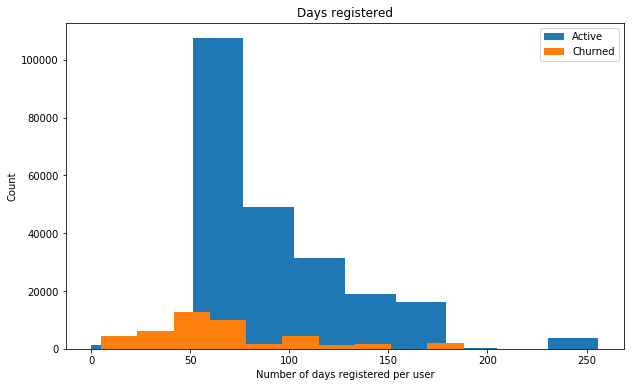


Average number of days registered for churned users:
+--------------------+
|avg(days_registered)|
+--------------------+
|   67.64847093437946|
+--------------------+

Average number of days registered for active users:
+--------------------+
|avg(days_registered)|
+--------------------+
|   92.97668995670625|
+--------------------+



In [40]:
# average registration/usage length per user (days from registration date to ts for latest event)
# create dataframe with last timestamp (ts) per user
df_last = df_clean.groupBy('userId').agg(max('ts').alias('last_interaction'))

# join dataframes and add column 'days_registered' with number of days from registration date to ts for last event
df_reg = df_last.join(df_clean, on='userId').select(
    df_last['*'], df_clean['registration'], df_clean['churn']).withColumn(
    'days_registered', datediff(df_last['last_interaction'], df_clean['registration']))

# graph of number of days registered per user group
# store columns to be used as pandas dataframe
df_reg_pd = df_reg.select('churn', 'days_registered').toPandas()

# plot results
plt.figure(figsize=(10,6))
plt.hist(df_reg_pd['days_registered'][df_reg_pd['churn'] == 0], label='Active')
plt.hist(df_reg_pd['days_registered'][df_reg_pd['churn'] == 1], label='Churned')
plt.legend(loc='upper right')
plt.title('Days registered')
plt.xlabel('Number of days registered per user')
plt.ylabel('Count')
plt.show()

print('')

# get average number of days registered for churned users
print('Average number of days registered for churned users:')
df_reg.where(col('churn') == 1).agg(avg('days_registered')).show()

# get average number of days registered for active users
print('Average number of days registered for active users:')
df_reg.where(col('churn') == 0).agg(avg('days_registered')).show()

Active users are registered for more days than churned users

In [41]:
# average number of unique artists played per user
print('Average number of unique artists played per churned user: {:.0f}'.format(
    df_clean.where(col('churn') == 1).groupBy('artist').count().count() / df_clean.where(
    col('churn') == 1).groupBy('userId').count().count()))

print('Average number of unique artists played per active user: {:.0f}'.format(
    df_clean.where(col('churn') == 0).groupBy('artist').count().count() / df_clean.where(
    col('churn') == 0).groupBy('userId').count().count()))

print('')

# average number of unique songs played per user
print('Average number of unique songs played per churned user: {:.0f}'.format(
    df_clean.where(col('churn') == 1).groupBy('song').count().count() / df_clean.where(
    col('churn') == 1).groupBy('userId').count().count()))

print('Average number of unique songs played per active user: {:.0f}'.format(
    df_clean.where(col('churn') == 0).groupBy('song').count().count() / df_clean.where(
    col('churn') == 0).groupBy('userId').count().count()))

Average number of unique artists played per churned user: 162
Average number of unique artists played per active user: 96

Average number of unique songs played per churned user: 370
Average number of unique songs played per active user: 308


In [42]:
# average number of unique artists played per session
print('Average number of unique artists played per session for churned users: {:.0f}'.format(
    df_clean.where(col('churn') == 1).groupBy('artist').count().count() / df_clean.where(
    col('churn') == 1).groupBy('userId', 'sessionId').count().count()))

print('Average number of unique artists played per session for active users: {:.0f}'.format(
    df_clean.where(col('churn') == 0).groupBy('artist').count().count() / df_clean.where(
    col('churn') == 0).groupBy('userId', 'sessionId').count().count()))

print('')

# average number of unique songs played per session
print('Average number of unique songs played per session for churned users: {:.0f}'.format(
    df_clean.where(col('churn') == 1).groupBy('song').count().count() / df_clean.where(
    col('churn') == 1).groupBy('userId', 'sessionId').count().count()))

print('Average number of unique songs played per session for active users: {:.0f}'.format(
    df_clean.where(col('churn') == 0).groupBy('song').count().count() / df_clean.where(
    col('churn') == 0).groupBy('userId', 'sessionId').count().count()))

Average number of unique artists played per session for churned users: 16
Average number of unique artists played per session for active users: 6

Average number of unique songs played per session for churned users: 36
Average number of unique songs played per session for active users: 20


In [43]:
# percent paid and free plans of churned users
print('Share of churned users that are on a paid plan: {:.0f}%'.format(
    df_clean.where((df_clean.level == 'paid') & (df_clean.churn == 1)).groupBy('userId').count().count() /
    df_clean.where(df_clean.churn == 1).groupBy('userId', 'level').count().count() * 100))

print('Share of churned users that are on a free plan: {:.0f}%'.format(
    df_clean.where((df_clean.level == 'free') & (df_clean.churn == 1)).groupBy('userId').count().count() /
    df_clean.where(df_clean.churn == 1).groupBy('userId', 'level').count().count() * 100))

print('')

# percent paid and free plans of active users
print('Share of active users that are on a paid plan: {:.0f}%'.format(
    df_clean.where((df_clean.level == 'paid') & (df_clean.churn == 0)).groupBy('userId').count().count() /
    df_clean.where(df_clean.churn == 0).groupBy('userId', 'level').count().count() * 100))

print('Share of active users that are on a free plan: {:.0f}%'.format(
    df_clean.where((df_clean.level == 'free') & (df_clean.churn == 0)).groupBy('userId').count().count() /
    df_clean.where(df_clean.churn == 0).groupBy('userId', 'level').count().count() * 100))

Share of churned users that are on a paid plan: 44%
Share of churned users that are on a free plan: 56%

Share of active users that are on a paid plan: 46%
Share of active users that are on a free plan: 54%


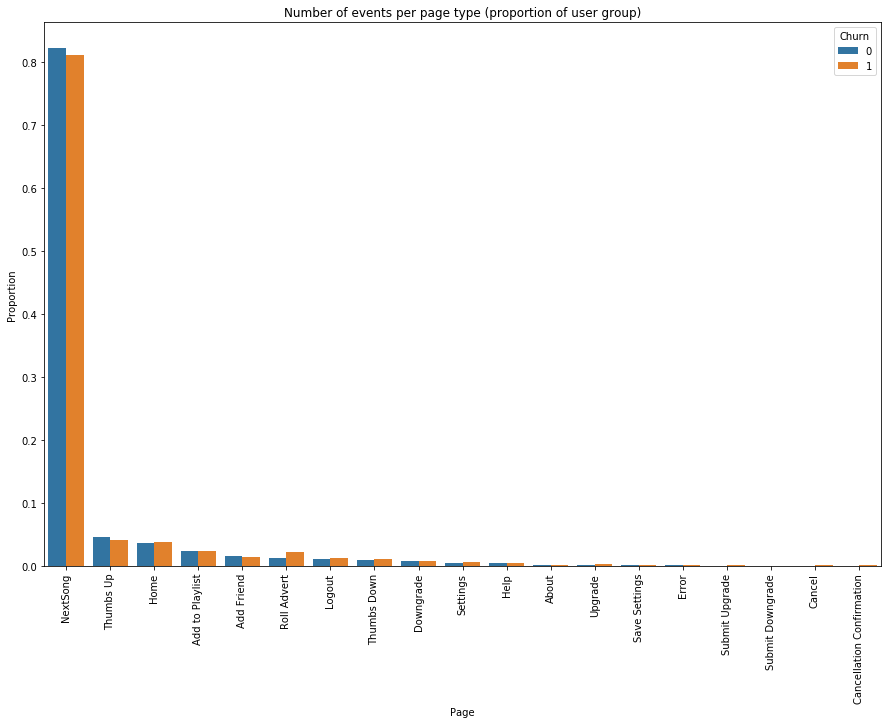


Number of events per page type for all events with a churned user:
+--------------------+-----+
|                page|count|
+--------------------+-----+
|            NextSong|36394|
|           Thumbs Up| 1859|
|                Home| 1672|
|     Add to Playlist| 1038|
|         Roll Advert|  967|
|          Add Friend|  636|
|              Logout|  553|
|         Thumbs Down|  496|
|           Downgrade|  337|
|            Settings|  270|
|                Help|  239|
|             Upgrade|  112|
|       Save Settings|   58|
|               About|   56|
|              Cancel|   52|
|Cancellation Conf...|   52|
|               Error|   32|
|      Submit Upgrade|   32|
|    Submit Downgrade|    9|
+--------------------+-----+

Number of events per page type for all events with active users:
+----------------+------+
|            page| count|
+----------------+------+
|        NextSong|191714|
|       Thumbs Up| 10692|
|            Home|  8410|
| Add to Playlist|  5488|
|      Add Friend

In [44]:
# graph of number of events per page type per user group
# plot results as proportions instead of counts
# source: https://stackoverflow.com/questions/35692781/python-plotting-percentage-in-seaborn-bar-plot
plt.figure(figsize=(15,10))

df_page_pd = df_clean.select('churn', 'page').toPandas()
x, y, hue = 'page', 'proportion', 'churn'
hue_order = ['Active users', 'Churned users']

(df_page_pd[x]
 .groupby(df_page_pd[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, 'data'), x=x, y=y, hue=hue))

plt.legend(loc='upper right', title='Churn')
plt.title('Number of events per page type (proportion of user group)')
plt.xlabel('Page')
plt.ylabel('Proportion')
plt.xticks(rotation=90)
plt.show()

print('')

print('Number of events per page type for all events with a churned user:')
df_clean.where(col('churn') == 1).groupBy('page').count().sort(desc('count')).show()

print('Number of events per page type for all events with active users:')
df_clean.where(col('churn') == 0).groupBy('page').count().sort(desc('count')).show()

In [45]:
# average number of songs played for churned and active users
print('Average number of songs played for churned users: {:.0f}'.format(
    df_clean.where((df_clean.page == 'NextSong') & (df_clean.churn == 1)).count() /
    df_clean.where(df_clean.churn == 1).groupBy('userId').count().count()))

print('Average number of songs played for active users: {:.0f}'.format(
    df_clean.where((df_clean.page == 'NextSong') & (df_clean.churn == 0)).count() /
    df_clean.where(df_clean.churn == 0).groupBy('userId').count().count()))

Average number of songs played for churned users: 700
Average number of songs played for active users: 1108


In [46]:
# average number of thumbs up for churned and active users
print('Average number of thumbs up for churned users: {:.0f}'.format(
    df_clean.where((df_clean.page == 'Thumbs Up') & (df_clean.churn == 1)).count() /
    df_clean.where(df_clean.churn == 1).groupBy('userId').count().count()))

print('Average number of thumbs up for active users: {:.0f}'.format(
    df_clean.where((df_clean.page == 'Thumbs Up') & (df_clean.churn == 0)).count() /
    df_clean.where(df_clean.churn == 0).groupBy('userId').count().count()))

Average number of thumbs up for churned users: 36
Average number of thumbs up for active users: 62


In [47]:
# average number of home page visits for churned and active users
print('Average number of home page visits for churned users: {:.0f}'.format(
    df_clean.where((df_clean.page == 'Home') & (df_clean.churn == 1)).count() /
    df_clean.where(df_clean.churn == 1).groupBy('userId').count().count()))

print('Average number of home page visits for active users: {:.0f}'.format(
    df_clean.where((df_clean.page == 'Home') & (df_clean.churn == 0)).count() /
    df_clean.where(df_clean.churn == 0).groupBy('userId').count().count()))

Average number of home page visits for churned users: 32
Average number of home page visits for active users: 49


In [48]:
# average number of added friends for churned and active users
print('Average number of added friends for churned users: {:.0f}'.format(
    df_clean.where((df_clean.page == 'Add Friend') & (df_clean.churn == 1)).count() /
    df_clean.where(df_clean.churn == 1).groupBy('userId').count().count()))

print('Average number of added friends for active users: {:.0f}'.format(
    df_clean.where((df_clean.page == 'Add Friend') & (df_clean.churn == 0)).count() /
    df_clean.where(df_clean.churn == 0).groupBy('userId').count().count()))

Average number of added friends for churned users: 12
Average number of added friends for active users: 21


In [49]:
# average number of ads received for churned and active users
print('Average number of ads received for churned users: {:.0f}'.format(
    df_clean.where((df_clean.page == 'Roll Advert') & (df_clean.churn == 1)).count() /
    df_clean.where(df_clean.churn == 1).groupBy('userId').count().count()))

print('Average number of ads received for active users: {:.0f}'.format(
    df_clean.where((df_clean.page == 'Roll Advert') & (df_clean.churn == 0)).count() /
    df_clean.where(df_clean.churn == 0).groupBy('userId').count().count()))

Average number of ads received for churned users: 19
Average number of ads received for active users: 17


In [50]:
# average number of logouts for churned and active users
print('Average number of logouts for churned users: {:.0f}'.format(
    df_clean.where((df_clean.page == 'Logout') & (df_clean.churn == 1)).count() /
    df_clean.where(df_clean.churn == 1).groupBy('userId').count().count()))

print('Average number of logouts for active users: {:.0f}'.format(
    df_clean.where((df_clean.page == 'Logout') & (df_clean.churn == 0)).count() /
    df_clean.where(df_clean.churn == 0).groupBy('userId').count().count()))

Average number of logouts for churned users: 11
Average number of logouts for active users: 15


In [51]:
# average number of thumbs down for churned and active users
print('Average number of thumbs down for churned users: {:.0f}'.format(
    df_clean.where((df_clean.page == 'Thumbs Down') & (df_clean.churn == 1)).count() /
    df_clean.where(df_clean.churn == 1).groupBy('userId').count().count()))

print('Average number of thumbs down for active users: {:.0f}'.format(
    df_clean.where((df_clean.page == 'Thumbs Down') & (df_clean.churn == 0)).count() /
    df_clean.where(df_clean.churn == 0).groupBy('userId').count().count()))

Average number of thumbs down for churned users: 10
Average number of thumbs down for active users: 12


In [52]:
# average number of settings page visits for churned and active users
print('Average number of settings page visits for churned users: {:.0f}'.format(
    df_clean.where((df_clean.page == 'Settings') & (df_clean.churn == 1)).count() /
    df_clean.where(df_clean.churn == 1).groupBy('userId').count().count()))

print('Average number of settings page visits for active users: {:.0f}'.format(
    df_clean.where((df_clean.page == 'Settings') & (df_clean.churn == 0)).count() /
    df_clean.where(df_clean.churn == 0).groupBy('userId').count().count()))

Average number of settings page visits for churned users: 5
Average number of settings page visits for active users: 7


In [53]:
# average number of plan upgrades for churned and active users
print('Average number of plan upgrades for churned users: {:.0f}'.format(
    df_clean.where((df_clean.page == 'Upgrade') & (df_clean.churn == 1)).count() /
    df_clean.where(df_clean.churn == 1).groupBy('userId').count().count()))

print('Average number of plan upgrades for active users: {:.0f}'.format(
    df_clean.where((df_clean.page == 'Upgrade') & (df_clean.churn == 0)).count() /
    df_clean.where(df_clean.churn == 0).groupBy('userId').count().count()))

Average number of plan upgrades for churned users: 2
Average number of plan upgrades for active users: 2


In [54]:
# number of females in dataset
print('Number of female users in dataset: {:.0f}'.format(
df_clean.where(df_clean.gender == 'F').groupBy('userId').count().count()))

# number of males in dataset
print('Number of male users in dataset: {:.0f}'.format(
df_clean.where(df_clean.gender == 'M').groupBy('userId').count().count()))

Number of female users in dataset: 104
Number of male users in dataset: 121


In [55]:
# percent female of all events
print('Percentage of all events that where made by females: {:.0f}%'.format(
df_clean.where(df_clean.gender == 'F').count() / df_clean.count() * 100))

# percent male of all events
print('Percentage of all events that where made by males: {:.0f}%'.format(
df_clean.where(df_clean.gender == 'M').count() / df_clean.count() * 100))

Percentage of all events that where made by females: 56%
Percentage of all events that where made by males: 44%


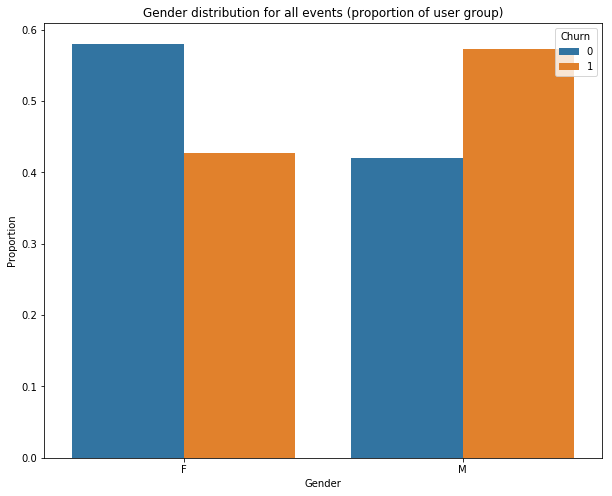


Share of churned users that are male: 62%
Share of churned users that are female: 38%

Share of active users that are male: 51%
Share of active users that are female: 49%


In [56]:
plt.figure(figsize=(10,8))

df_gender_pd = df_clean.select('churn', 'gender').toPandas()
x, y, hue = 'gender', 'proportion', 'churn'
hue_order = ['Active users', 'Churned users']

(df_gender_pd[x]
 .groupby(df_gender_pd[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, 'data'), x=x, y=y, hue=hue))

plt.legend(loc='upper right', title='Churn')
plt.title('Gender distribution for all events (proportion of user group)')
plt.xlabel('Gender')
plt.ylabel('Proportion')
plt.show()

print('')

# percent males and females of churned users
print('Share of churned users that are male: {:.0f}%'.format(
    df_clean.where((df_clean.gender == 'M') & (df_clean.churn == 1)).groupBy('userId').count().count() /
    df_clean.where(df_clean.churn == 1).groupBy('userId', 'gender').count().count() * 100))

print('Share of churned users that are female: {:.0f}%'.format(
    df_clean.where((df_clean.gender == 'F') & (df_clean.churn == 1)).groupBy('userId').count().count() /
    df_clean.where(df_clean.churn == 1).groupBy('userId', 'gender').count().count() * 100))

print('')

# percent males and females of active users
print('Share of active users that are male: {:.0f}%'.format(
    df_clean.where((df_clean.gender == 'M') & (df_clean.churn == 0)).groupBy('userId').count().count() /
    df_clean.where(df_clean.churn == 0).groupBy('userId', 'gender').count().count() * 100))

print('Share of active users that are female: {:.0f}%'.format(
    df_clean.where((df_clean.gender == 'F') & (df_clean.churn == 0)).groupBy('userId').count().count() /
    df_clean.where(df_clean.churn == 0).groupBy('userId', 'gender').count().count() * 100))

In [57]:
# percent churned and active of all females
print('Share of females that are churned users: {:.0f}%'.format(
    df_clean.where((df_clean.gender == 'F') & (df_clean.churn == 1)).groupBy('userId').count().count() /
    df_clean.where(df_clean.gender == 'F').groupBy('userId').count().count() * 100))

print('Share of females that are active users: {:.0f}%'.format(
    df_clean.where((df_clean.gender == 'F') & (df_clean.churn == 0)).groupBy('userId').count().count() /
    df_clean.where(df_clean.gender == 'F').groupBy('userId').count().count() * 100))
    
print('')

# percent churned and active of all males
print('Share of males that are churned users: {:.0f}%'.format(
    df_clean.where((df_clean.gender == 'M') & (df_clean.churn == 1)).groupBy('userId').count().count() /
    df_clean.where(df_clean.gender == 'M').groupBy('userId').count().count() * 100))

print('Share of males that are active users: {:.0f}%'.format(
    df_clean.where((df_clean.gender == 'M') & (df_clean.churn == 0)).groupBy('userId').count().count() /
    df_clean.where(df_clean.gender == 'M').groupBy('userId').count().count() * 100))

Share of females that are churned users: 19%
Share of females that are active users: 81%

Share of males that are churned users: 26%
Share of males that are active users: 74%


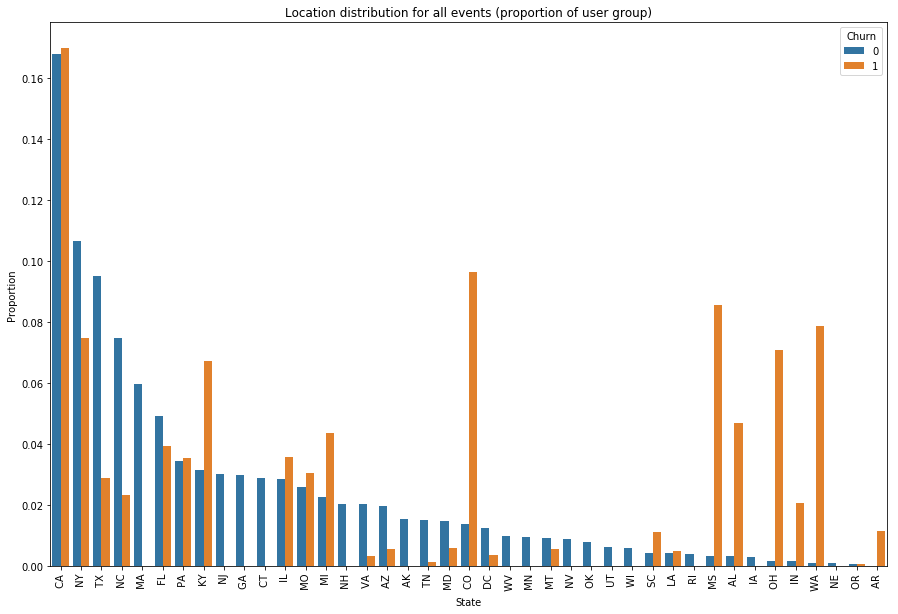


States for all events with a churned user:
+-----+-----+
|state|count|
+-----+-----+
|   CA| 7613|
|   CO| 4317|
|   MS| 3839|
|   WA| 3526|
|   NY| 3356|
|   OH| 3173|
|   KY| 3016|
|   AL| 2102|
|   MI| 1958|
|   FL| 1763|
|   IL| 1603|
|   PA| 1580|
|   MO| 1361|
|   TX| 1294|
|   NC| 1050|
|   IN|  918|
|   AR|  520|
|   SC|  494|
|   MD|  268|
|   MT|  254|
|   AZ|  251|
|   LA|  216|
|   DC|  158|
|   VA|  149|
|   TN|   62|
|   OR|   23|
+-----+-----+

States for all events with an active user:
+-----+-----+
|state|count|
+-----+-----+
|   CA|39158|
|   NY|24864|
|   TX|22200|
|   NC|17418|
|   MA|13873|
|   FL|11427|
|   PA| 8048|
|   KY| 7326|
|   NJ| 7001|
|   GA| 6952|
|   CT| 6720|
|   IL| 6616|
|   MO| 6059|
|   MI| 5258|
|   NH| 4764|
|   VA| 4748|
|   AZ| 4595|
|   AK| 3563|
|   TN| 3535|
|   MD| 3424|
|   CO| 3176|
|   DC| 2932|
|   WV| 2278|
|   MN| 2241|
|   MT| 2132|
|   NV| 2042|
|   OK| 1842|
|   UT| 1419|
|   WI| 1342|
|   SC| 1011|
|   LA|  955|
|   RI|  927|
| 

In [58]:
# graph of location distribution for all events per user group
plt.figure(figsize=(15,10))

df_location_pd = df_clean.select('churn', 'state').toPandas()
x, y, hue = 'state', 'proportion', 'churn'
hue_order = ['Active users', 'Churned users']

(df_location_pd[x]
 .groupby(df_location_pd[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, 'data'), x=x, y=y, hue=hue))

plt.legend(loc='upper right', title='Churn')
plt.title('Location distribution for all events (proportion of user group)')
plt.xlabel('State')
plt.ylabel('Proportion')
plt.xticks(rotation=90)
plt.show()

print('')

print('States for all events with a churned user:')
df_clean.where(col('churn') == 1).groupBy('state').count().sort(desc('count')).show(40)

print('States for all events with an active user:')
df_clean.where(col('churn') == 0).groupBy('state').count().sort(desc('count')).show(40)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [59]:
# calculate and add new columns

# create partitions
w1 = Window.partitionBy('userId')
w2 = Window.partitionBy('userId', 'sessionId')
w3 = Window.partitionBy('userId', 'artist')
w4 = Window.partitionBy('userId', 'song')

# total_events - column with total number of events per user
# create dataframe with row counts per user
df_events = df_clean.select('userId', count('userId').over(w1).alias('total_events')).distinct()
df_events = df_events.select(col('userId').alias('userId1'), 'total_events')

# total_sessions - column with total number of sessions per user
# create dataframe with session counts per user
df_sessions = df_clean.select('userId', 'sessionId', count('userId').over(w2).alias('count')).distinct()
df_sessions = df_sessions.withColumn('total_sessions', count('sessionId').over(w1))
df_sessions = df_sessions.dropDuplicates(['userId'])
df_sessions = df_sessions.select(col('userId').alias('userId2'), 'total_sessions')

# min_ts_session and max_ts_session - columns with timestamp from first and latest event per user and session
# session_length - column with session length in hours per session
# avg_session_length - column with average session length per user
# udf to convert time to correct format and show time difference in hours
time_delta = udf(lambda y, x: (datetime.datetime.strptime(y, '%Y-%m-%d %H:%M:%S') - 
                                   datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')).total_seconds()/3600)

# create columns with timestamp (ts) from first and latest event per user and session
df_clean = df_clean.withColumn('min_ts_session', min('ts').over(w2))
df_clean = df_clean.withColumn('max_ts_session', max('ts').over(w2))

# apply udf when creating column with time difference (in hours)
df_clean = df_clean.withColumn('session_length', time_delta(df_clean['max_ts_session'], 
                                                            df_clean['min_ts_session']).cast('float'))

# create column with average session length per user (in hours)
df_clean = df_clean.withColumn('avg_session_length', avg('session_length').over(w1))
    
# latest_ts and days_registered - columns with timestamp from latest event and with number of days registered
# create column with timestamp (ts) from latest event per user
df_clean = df_clean.withColumn('latest_ts', max('ts').over(w1))

# create column 'days_registered'
df_clean = df_clean.withColumn('days_registered', datediff(df_clean['latest_ts'], df_clean['registration']))

# unique_artists - column with number of unique artists played per user
# create dataframe with artist counts per user
df_artist = df_clean.select('userId', 'artist', count('userId').over(w3).alias('count')).distinct()
df_artist = df_artist.withColumn('unique_artists', count('artist').over(w1))
df_artist = df_artist.dropDuplicates(['userId'])
df_artist = df_artist.select(col('userId').alias('userId3'), 'unique_artists')

# unique_songs - column with number of unique songs played per user
# create dataframe with song counts per user
df_song = df_clean.select('userId', 'song', count('userId').over(w4).alias('count')).distinct()
df_song = df_song.withColumn('unique_songs', count('song').over(w1))
df_song = df_song.dropDuplicates(['userId'])
df_song = df_song.select(col('userId').alias('userId4'), 'unique_songs')

# total_nextsong - column with number of 'NextSong' events per user
# create dataframe with 'page = NextSong' counts per user
df_nextsong = df_clean.where(df_clean.page == 'NextSong').select(
    'userId', count('userId').over(w1).alias('total_nextsong')).distinct()
df_nextsong = df_nextsong.select(col('userId').alias('userId5'), 'total_nextsong')

# total_thumbsup - column with number of 'Thumbs Up' events per user
# create dataframe with 'page = Thumbs Up' counts per user
df_thumbsup = df_clean.where(df_clean.page == 'Thumbs Up').select(
    'userId', count('userId').over(w1).alias('total_thumbsup')).distinct()
df_thumbsup = df_thumbsup.select(col('userId').alias('userId6'), 'total_thumbsup')

# total_home - column with number of 'Home' events per user
# create dataframe with 'page = Home' counts per user
df_home = df_clean.where(df_clean.page == 'Home').select(
    'userId', count('userId').over(w1).alias('total_home')).distinct()
df_home = df_home.select(col('userId').alias('userId7'), 'total_home')

# total_addfriend - column with number of 'Add Friend' events per user
# create dataframe with 'page = Add Friend' counts per user
df_addfriend = df_clean.where(df_clean.page == 'Add Friend').select(
    'userId', count('userId').over(w1).alias('total_addfriend')).distinct()
df_addfriend = df_addfriend.select(col('userId').alias('userId8'), 'total_addfriend')

# total_rolladvert - column with number of 'Roll Advert' events per user
# create dataframe with 'page = Roll Advert' counts per user
df_rolladvert = df_clean.where(df_clean.page == 'Roll Advert').select(
    'userId', count('userId').over(w1).alias('total_rolladvert')).distinct()
df_rolladvert = df_rolladvert.select(col('userId').alias('userId9'), 'total_rolladvert')

# latest_event - column indicating row with latest event per user
df_clean = df_clean.withColumn('latest_event', when(df_clean.latest_ts == df_clean.ts, 1).otherwise(0))

# keep only row with latest event per user in data to be used for modeling
df_ml = df_clean.where(col('latest_event') == 1)

# drop duplicates from dataframe
df_ml = df_ml.dropDuplicates(['userId'])

# recode 'gender' to numerical binary
df_ml = df_ml.withColumn('gender', when(df_ml.gender == 'F', 1).otherwise(0))

# only keep columns to be used in modeling and replace NaN with 0
df_ml = df_ml.select('userId', 'churn', 'gender', 'state', 'avg_session_length', 
                     'days_registered', ).fillna(0)

# add columns to df_ml and replace NaN with 0 for column
# add column 'total_events'
df_ml = df_ml.join(df_events, df_ml.userId == df_events.userId1, how='left').select(
    df_ml['*'], df_events['total_events']).fillna(0, subset=['total_events'])

# add column 'total_sessions'
df_ml = df_ml.join(df_sessions, df_ml.userId == df_sessions.userId2, how='left').select(
    df_ml['*'], df_sessions['total_sessions']).fillna(0, subset=['total_sessions'])

# add column 'unique_artists'
df_ml = df_ml.join(df_artist, df_ml.userId == df_artist.userId3, how='left').select(
    df_ml['*'], df_artist['unique_artists']).fillna(0, subset=['unique_artists'])

# add column 'unique_songs'
df_ml = df_ml.join(df_song, df_ml.userId == df_song.userId4, how='left').select(
    df_ml['*'], df_song['unique_songs']).fillna(0, subset=['unique_songs'])

# add column 'total_nextsong'
df_ml = df_ml.join(df_nextsong, df_ml.userId == df_nextsong.userId5, how='left').select(
    df_ml['*'], df_nextsong['total_nextsong']).fillna(0, subset=['total_nextsong'])

# add column 'total_thumbsup'
df_ml = df_ml.join(df_thumbsup, df_ml.userId == df_thumbsup.userId6, how='left').select(
    df_ml['*'], df_thumbsup['total_thumbsup']).fillna(0, subset=['total_thumbsup'])

# add column 'total_home'
df_ml = df_ml.join(df_home, df_ml.userId == df_home.userId7, how='left').select(
    df_ml['*'], df_home['total_home']).fillna(0, subset=['total_home'])

# add column 'total_addfriend'
df_ml = df_ml.join(df_addfriend, df_ml.userId == df_addfriend.userId8, how='left').select(
    df_ml['*'], df_addfriend['total_addfriend']).fillna(0, subset=['total_addfriend'])

# add column 'total_rolladvert'
df_ml = df_ml.join(df_rolladvert, df_ml.userId == df_rolladvert.userId9, how='left').select(
    df_ml['*'], df_rolladvert['total_rolladvert']).fillna(0, subset=['total_rolladvert'])

In [61]:
df_ml.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = false)
 |-- gender: integer (nullable = false)
 |-- state: string (nullable = true)
 |-- avg_session_length: double (nullable = false)
 |-- days_registered: integer (nullable = true)
 |-- total_events: long (nullable = true)
 |-- total_sessions: long (nullable = true)
 |-- unique_artists: long (nullable = true)
 |-- unique_songs: long (nullable = true)
 |-- total_nextsong: long (nullable = true)
 |-- total_thumbsup: long (nullable = true)
 |-- total_home: long (nullable = true)
 |-- total_addfriend: long (nullable = true)
 |-- total_rolladvert: long (nullable = true)



In [62]:
df_ml.cache()

DataFrame[userId: string, churn: int, gender: int, state: string, avg_session_length: double, days_registered: int, total_events: bigint, total_sessions: bigint, unique_artists: bigint, unique_songs: bigint, total_nextsong: bigint, total_thumbsup: bigint, total_home: bigint, total_addfriend: bigint, total_rolladvert: bigint]

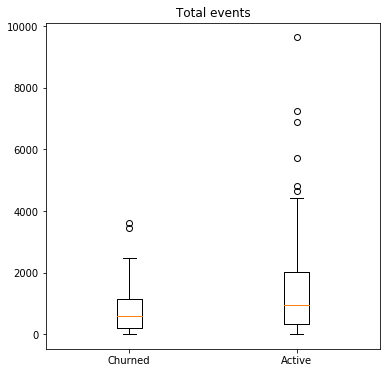

Basic statistics for churned users:
+-------+-----------------+
|summary|     total_events|
+-------+-----------------+
|  count|               52|
|   mean|862.7692307692307|
| stddev|852.2623782542744|
|    min|               11|
|    25%|              187|
|    50%|              552|
|    75%|             1102|
|    max|             3603|
+-------+-----------------+

Basic statistics for active users:
+-------+------------------+
|summary|      total_events|
+-------+------------------+
|  count|               173|
|   mean|1348.4971098265896|
| stddev| 1425.428636571019|
|    min|                 6|
|    25%|               321|
|    50%|               940|
|    75%|              2005|
|    max|              9632|
+-------+------------------+



In [63]:
# plot total_events
# store column values as array
churn = df_ml.select('total_events').where(df_ml['churn'] == 1).toPandas().values.tolist()
active = df_ml.select('total_events').where(df_ml['churn'] == 0).toPandas().values.tolist()

# plot boxplots of both arrays in the same plot
data = [churn, active]
fig, ax = plt.subplots(figsize=(6,6))
ax.boxplot(data)
ax.set_xticklabels(['Churned', 'Active'])
plt.title('Total events')
plt.show()

# plot basic statistics
print('Basic statistics for churned users:')
df_ml.select('total_events').where(df_ml['churn'] == 1).summary().show()
print('Basic statistics for active users:')
df_ml.select('total_events').where(df_ml['churn'] == 0).summary().show()

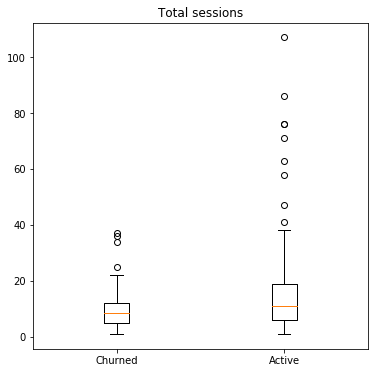

Basic statistics for churned users:
+-------+------------------+
|summary|    total_sessions|
+-------+------------------+
|  count|                52|
|   mean|10.326923076923077|
| stddev|  8.61080295917924|
|    min|                 1|
|    25%|                 5|
|    50%|                 8|
|    75%|                12|
|    max|                37|
+-------+------------------+

Basic statistics for active users:
+-------+------------------+
|summary|    total_sessions|
+-------+------------------+
|  count|               173|
|   mean|15.254335260115607|
| stddev|15.866963127421307|
|    min|                 1|
|    25%|                 6|
|    50%|                11|
|    75%|                19|
|    max|               107|
+-------+------------------+



In [64]:
# plot total_sessions
# store column values as array
churn = df_ml.select('total_sessions').where(df_ml['churn'] == 1).toPandas().values.tolist()
active = df_ml.select('total_sessions').where(df_ml['churn'] == 0).toPandas().values.tolist()

# plot boxplots of both arrays in the same plot
data = [churn, active]
fig, ax = plt.subplots(figsize=(6,6))
ax.boxplot(data)
ax.set_xticklabels(['Churned', 'Active'])
plt.title('Total sessions')
plt.show()

# plot basic statistics
print('Basic statistics for churned users:')
df_ml.select('total_sessions').where(df_ml['churn'] == 1).summary().show()
print('Basic statistics for active users:')
df_ml.select('total_sessions').where(df_ml['churn'] == 0).summary().show()

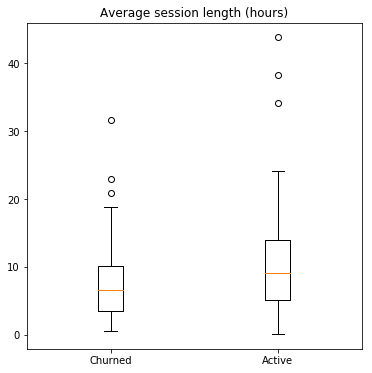

Basic statistics for churned users:
+-------+------------------+
|summary|avg_session_length|
+-------+------------------+
|  count|                52|
|   mean| 8.048868485300888|
| stddev| 6.345236883473346|
|    min|0.4927777647972107|
|    25%|3.3211112022399902|
|    50%|  6.38861172152296|
|    75%| 9.441156521151143|
|    max| 31.70917101300778|
+-------+------------------+

Basic statistics for active users:
+-------+-------------------+
|summary| avg_session_length|
+-------+-------------------+
|  count|                173|
|   mean| 10.080303650836603|
| stddev|  6.913496501718813|
|    min|0.11666666716337204|
|    25%|  5.094972980089402|
|    50%|    9.1002779006958|
|    75%| 13.971460027764826|
|    max|  43.79557182164721|
+-------+-------------------+



In [65]:
# plot avg_session_length
# store column values as list
churn = df_ml.select('avg_session_length').where(df_ml['churn'] == 1).toPandas().values.tolist()
active = df_ml.select('avg_session_length').where(df_ml['churn'] == 0).toPandas().values.tolist()

# plot boxplots of both lists in the same plot
data = [churn, active]
fig, ax = plt.subplots(figsize=(6,6))
ax.boxplot(data)
ax.set_xticklabels(['Churned', 'Active'])
plt.title('Average session length (hours)')
plt.show()

# plot basic statistics
print('Basic statistics for churned users:')
df_ml.select('avg_session_length').where(df_ml['churn'] == 1).summary().show()
print('Basic statistics for active users:')
df_ml.select('avg_session_length').where(df_ml['churn'] == 0).summary().show()

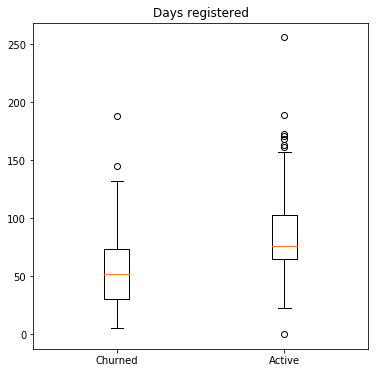

Basic statistics for churned users:
+-------+------------------+
|summary|   days_registered|
+-------+------------------+
|  count|                52|
|   mean| 57.36538461538461|
| stddev|36.587809416366895|
|    min|                 5|
|    25%|                29|
|    50%|                50|
|    75%|                73|
|    max|               188|
+-------+------------------+

Basic statistics for active users:
+-------+-----------------+
|summary|  days_registered|
+-------+-----------------+
|  count|              173|
|   mean|86.56647398843931|
| stddev|35.33432397636966|
|    min|                0|
|    25%|               65|
|    50%|               76|
|    75%|              103|
|    max|              256|
+-------+-----------------+



In [66]:
# plot days_registered
# store column values as list
churn = df_ml.select('days_registered').where(df_ml['churn'] == 1).toPandas().values.tolist()
active = df_ml.select('days_registered').where(df_ml['churn'] == 0).toPandas().values.tolist()

# plot boxplots of both lists in the same plot
data = [churn, active]
fig, ax = plt.subplots(figsize=(6,6))
ax.boxplot(data)
ax.set_xticklabels(['Churned', 'Active'])
plt.title('Days registered')
plt.show()

# plot basic statistics
print('Basic statistics for churned users:')
df_ml.select('days_registered').where(df_ml['churn'] == 1).summary().show()
print('Basic statistics for active users:')
df_ml.select('days_registered').where(df_ml['churn'] == 0).summary().show()

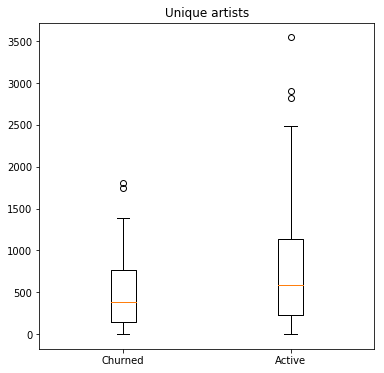

Basic statistics for churned users:
+-------+-----------------+
|summary|   unique_artists|
+-------+-----------------+
|  count|               52|
|   mean|518.6923076923077|
| stddev|455.9143167892335|
|    min|                8|
|    25%|              125|
|    50%|              374|
|    75%|              741|
|    max|             1804|
+-------+-----------------+

Basic statistics for active users:
+-------+-----------------+
|summary|   unique_artists|
+-------+-----------------+
|  count|              173|
|   mean|749.7861271676301|
| stddev| 633.235440098802|
|    min|                3|
|    25%|              226|
|    50%|              587|
|    75%|             1137|
|    max|             3544|
+-------+-----------------+



In [67]:
# plot unique_artists
# store column values as list
churn = df_ml.select('unique_artists').where(df_ml['churn'] == 1).toPandas().values.tolist()
active = df_ml.select('unique_artists').where(df_ml['churn'] == 0).toPandas().values.tolist()

# plot boxplots of both lists in the same plot
data = [churn, active]
fig, ax = plt.subplots(figsize=(6,6))
ax.boxplot(data)
ax.set_xticklabels(['Churned', 'Active'])
plt.title('Unique artists')
plt.show()

# plot basic statistics
print('Basic statistics for churned users:')
df_ml.select('unique_artists').where(df_ml['churn'] == 1).summary().show()
print('Basic statistics for active users:')
df_ml.select('unique_artists').where(df_ml['churn'] == 0).summary().show()

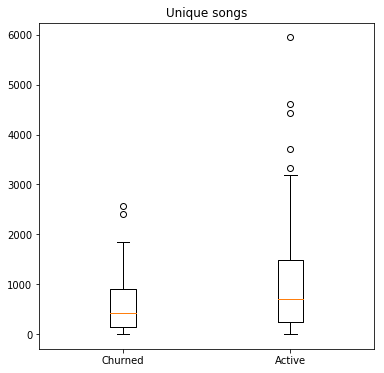

Basic statistics for churned users:
+-------+-----------------+
|summary|     unique_songs|
+-------+-----------------+
|  count|               52|
|   mean|638.3653846153846|
| stddev|619.5986692490094|
|    min|                8|
|    25%|              129|
|    50%|              412|
|    75%|              875|
|    max|             2562|
+-------+-----------------+

Basic statistics for active users:
+-------+-----------------+
|summary|     unique_songs|
+-------+-----------------+
|  count|              173|
|   mean|975.7687861271677|
| stddev|951.9128806124245|
|    min|                3|
|    25%|              239|
|    50%|              696|
|    75%|             1477|
|    max|             5946|
+-------+-----------------+



In [68]:
# plot unique_songs
# store column values as list
churn = df_ml.select('unique_songs').where(df_ml['churn'] == 1).toPandas().values.tolist()
active = df_ml.select('unique_songs').where(df_ml['churn'] == 0).toPandas().values.tolist()

# plot boxplots of both lists in the same plot
data = [churn, active]
fig, ax = plt.subplots(figsize=(6,6))
ax.boxplot(data)
ax.set_xticklabels(['Churned', 'Active'])
plt.title('Unique songs')
plt.show()

# plot basic statistics
print('Basic statistics for churned users:')
df_ml.select('unique_songs').where(df_ml['churn'] == 1).summary().show()
print('Basic statistics for active users:')
df_ml.select('unique_songs').where(df_ml['churn'] == 0).summary().show()

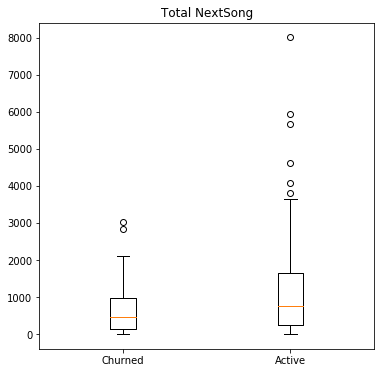

Basic statistics for churned users:
+-------+-----------------+
|summary|   total_nextsong|
+-------+-----------------+
|  count|               52|
|   mean|699.8846153846154|
| stddev|714.7376497666588|
|    min|                8|
|    25%|              133|
|    50%|              429|
|    75%|              927|
|    max|             3028|
+-------+-----------------+

Basic statistics for active users:
+-------+------------------+
|summary|    total_nextsong|
+-------+------------------+
|  count|               173|
|   mean|1108.1734104046243|
| stddev|1183.1467030410008|
|    min|                 3|
|    25%|               251|
|    50%|               747|
|    75%|              1640|
|    max|              8002|
+-------+------------------+



In [69]:
# plot total_nextsong
# store column values as list
churn = df_ml.select('total_nextsong').where(df_ml['churn'] == 1).toPandas().values.tolist()
active = df_ml.select('total_nextsong').where(df_ml['churn'] == 0).toPandas().values.tolist()

# plot boxplots of both lists in the same plot
data = [churn, active]
fig, ax = plt.subplots(figsize=(6,6))
ax.boxplot(data)
ax.set_xticklabels(['Churned', 'Active'])
plt.title('Total NextSong')
plt.show()

# plot basic statistics
print('Basic statistics for churned users:')
df_ml.select('total_nextsong').where(df_ml['churn'] == 1).summary().show()
print('Basic statistics for active users:')
df_ml.select('total_nextsong').where(df_ml['churn'] == 0).summary().show()

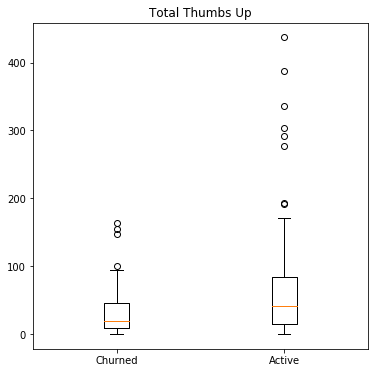

Basic statistics for churned users:
+-------+------------------+
|summary|    total_thumbsup|
+-------+------------------+
|  count|                52|
|   mean|             35.75|
| stddev|39.697816900513146|
|    min|                 0|
|    25%|                 8|
|    50%|                19|
|    75%|                45|
|    max|               163|
+-------+------------------+

Basic statistics for active users:
+-------+-----------------+
|summary|   total_thumbsup|
+-------+-----------------+
|  count|              173|
|   mean|61.80346820809248|
| stddev|70.41642406853158|
|    min|                0|
|    25%|               14|
|    50%|               41|
|    75%|               84|
|    max|              437|
+-------+-----------------+



In [70]:
# plot total_thumbsup
# store column values as list
churn = df_ml.select('total_thumbsup').where(df_ml['churn'] == 1).toPandas().values.tolist()
active = df_ml.select('total_thumbsup').where(df_ml['churn'] == 0).toPandas().values.tolist()

# plot boxplots of both lists in the same plot
data = [churn, active]
fig, ax = plt.subplots(figsize=(6,6))
ax.boxplot(data)
ax.set_xticklabels(['Churned', 'Active'])
plt.title('Total Thumbs Up')
plt.show()

# plot basic statistics
print('Basic statistics for churned users:')
df_ml.select('total_thumbsup').where(df_ml['churn'] == 1).summary().show()
print('Basic statistics for active users:')
df_ml.select('total_thumbsup').where(df_ml['churn'] == 0).summary().show()

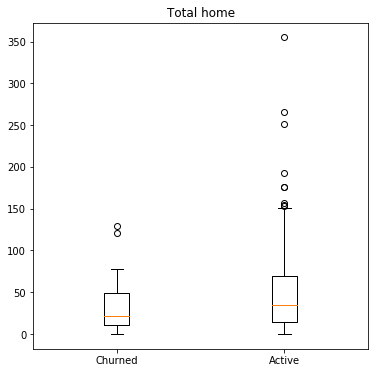

Basic statistics for churned users:
+-------+------------------+
|summary|        total_home|
+-------+------------------+
|  count|                52|
|   mean| 32.15384615384615|
| stddev|29.368106360328266|
|    min|                 0|
|    25%|                10|
|    50%|                21|
|    75%|                47|
|    max|               129|
+-------+------------------+

Basic statistics for active users:
+-------+-----------------+
|summary|       total_home|
+-------+-----------------+
|  count|              173|
|   mean|48.61271676300578|
| stddev|50.93618054493799|
|    min|                0|
|    25%|               14|
|    50%|               35|
|    75%|               69|
|    max|              355|
+-------+-----------------+



In [71]:
# plot total_home
# store column values as list
churn = df_ml.select('total_home').where(df_ml['churn'] == 1).toPandas().values.tolist()
active = df_ml.select('total_home').where(df_ml['churn'] == 0).toPandas().values.tolist()

# plot boxplots of both lists in the same plot
data = [churn, active]
fig, ax = plt.subplots(figsize=(6,6))
ax.boxplot(data)
ax.set_xticklabels(['Churned', 'Active'])
plt.title('Total home')
plt.show()

# plot basic statistics
print('Basic statistics for churned users:')
df_ml.select('total_home').where(df_ml['churn'] == 1).summary().show()
print('Basic statistics for active users:')
df_ml.select('total_home').where(df_ml['churn'] == 0).summary().show()

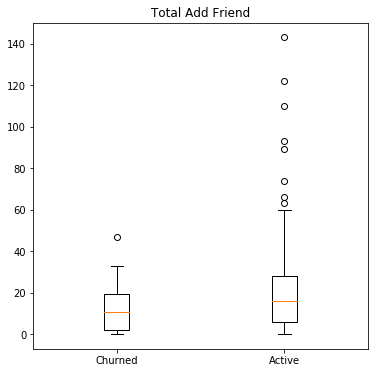

Basic statistics for churned users:
+-------+------------------+
|summary|   total_addfriend|
+-------+------------------+
|  count|                52|
|   mean| 12.23076923076923|
| stddev|11.157720240502051|
|    min|                 0|
|    25%|                 2|
|    50%|                10|
|    75%|                19|
|    max|                47|
+-------+------------------+

Basic statistics for active users:
+-------+------------------+
|summary|   total_addfriend|
+-------+------------------+
|  count|               173|
|   mean|21.046242774566473|
| stddev|22.286666946671954|
|    min|                 0|
|    25%|                 6|
|    50%|                16|
|    75%|                28|
|    max|               143|
+-------+------------------+



In [72]:
# plot total_addfriend
# store column values as list
churn = df_ml.select('total_addfriend').where(df_ml['churn'] == 1).toPandas().values.tolist()
active = df_ml.select('total_addfriend').where(df_ml['churn'] == 0).toPandas().values.tolist()

# plot boxplots of both lists in the same plot
data = [churn, active]
fig, ax = plt.subplots(figsize=(6,6))
ax.boxplot(data)
ax.set_xticklabels(['Churned', 'Active'])
plt.title('Total Add Friend')
plt.show()

# plot basic statistics
print('Basic statistics for churned users:')
df_ml.select('total_addfriend').where(df_ml['churn'] == 1).summary().show()
print('Basic statistics for active users:')
df_ml.select('total_addfriend').where(df_ml['churn'] == 0).summary().show()

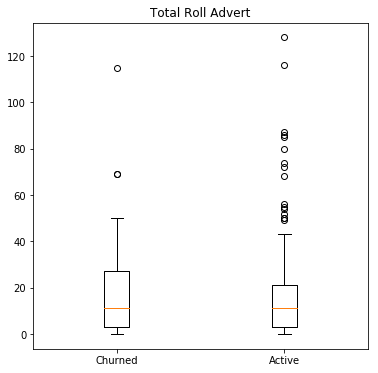

Basic statistics for churned users:
+-------+------------------+
|summary|  total_rolladvert|
+-------+------------------+
|  count|                52|
|   mean|18.596153846153847|
| stddev|21.799675852406267|
|    min|                 0|
|    25%|                 3|
|    50%|                11|
|    75%|                27|
|    max|               115|
+-------+------------------+

Basic statistics for active users:
+-------+------------------+
|summary|  total_rolladvert|
+-------+------------------+
|  count|               173|
|   mean| 17.14450867052023|
| stddev|21.527076957738625|
|    min|                 0|
|    25%|                 3|
|    50%|                11|
|    75%|                21|
|    max|               128|
+-------+------------------+



In [73]:
# plot total_rolladvert
# store column values as list
churn = df_ml.select('total_rolladvert').where(df_ml['churn'] == 1).toPandas().values.tolist()
active = df_ml.select('total_rolladvert').where(df_ml['churn'] == 0).toPandas().values.tolist()

# plot boxplots of both lists in the same plot
data = [churn, active]
fig, ax = plt.subplots(figsize=(6,6))
ax.boxplot(data)
ax.set_xticklabels(['Churned', 'Active'])
plt.title('Total Roll Advert')
plt.show()

# plot basic statistics
print('Basic statistics for churned users:')
df_ml.select('total_rolladvert').where(df_ml['churn'] == 1).summary().show()
print('Basic statistics for active users:')
df_ml.select('total_rolladvert').where(df_ml['churn'] == 0).summary().show()

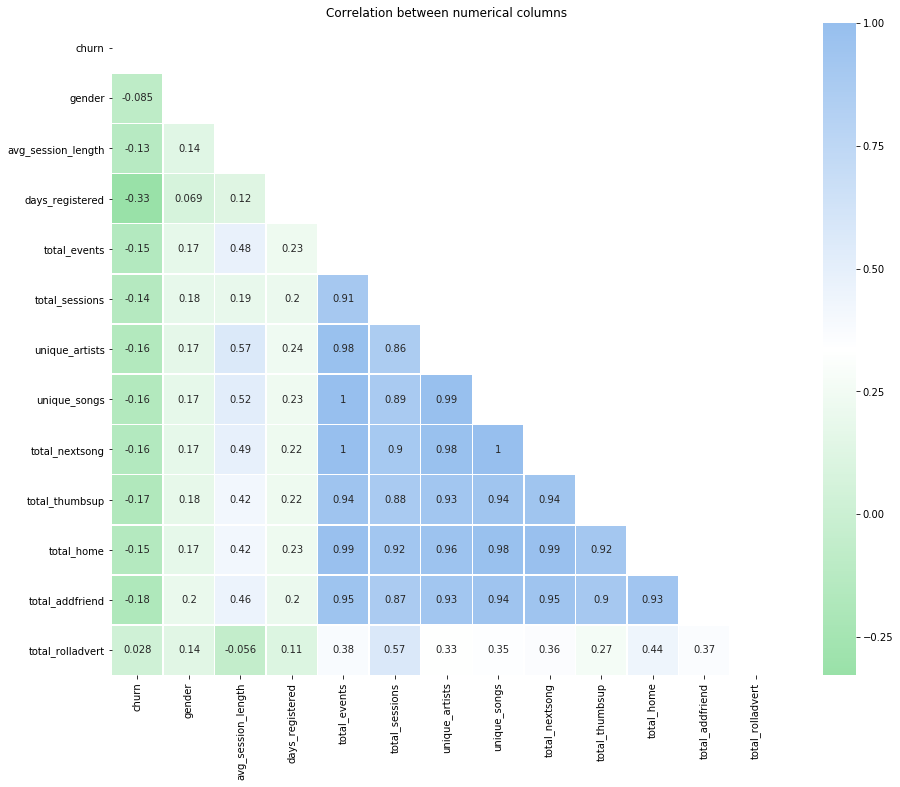

In [74]:
# correlation matrix of numerical columns
# create correlation matrix
df_corr = df_ml.toPandas().corr()

plt.figure(figsize=(15,12))
plt.title('Correlation between numerical columns')

# create a mask for the upper triangle
mask = np.zeros_like(df_corr)
mask[np.triu_indices_from(mask)] = True

# create custom color range for heatmap to match other graphs in notebook
cmap = mcolors.LinearSegmentedColormap.from_list('n',['#99E1A8', '#FFFFFF','#97BFEE'])

sns.heatmap(df_corr, mask=mask, annot=True, linewidths=0.5, cmap=cmap)
plt.show()

In [75]:
# data modeling preparation pipeline

# list of numerical columns
numerical_cols = ['avg_session_length',
                  'days_registered', 
                  'total_events', 
                  'total_sessions', 
                  'unique_artists',
                  'unique_songs', 
                  'total_nextsong', 
                  'total_thumbsup', 
                  'total_home', 
                  'total_addfriend', 
                  'total_rolladvert']

# convert sting column to index column
indexer = StringIndexer(inputCol='state', outputCol='stateIndex', handleInvalid='keep')
inputs = [indexer.getOutputCol(), 'gender']
# one hot encode categorical columns to numerical vector columns
encoder = OneHotEncoderEstimator(inputCols=inputs, outputCols=['stateVec', 'genderVec'], handleInvalid='keep')
# transform numerical columns to a single vector column
num_assembler = VectorAssembler(inputCols=numerical_cols, outputCol='num_features')
# apply scaler (MinMax scaler preserves original data distribution)
scaler = MinMaxScaler(inputCol='num_features', outputCol='scaled_features')
# transform all create vector columns into one vector column
assembler = VectorAssembler(inputCols=['stateVec', 'genderVec', 'scaled_features'], outputCol='features')
# create pipeline with above steps
data_pipeline = Pipeline(stages=[indexer, encoder, num_assembler, scaler, assembler])
# fit dataframe to pipleine and transform
df_ml = data_pipeline.fit(df_ml).transform(df_ml)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [76]:
# split data into train, validation and test sets
train, validation_test = df_ml.randomSplit([0.7, 0.3], seed = 79)
validation, test = validation_test.randomSplit([0.5, 0.5], seed = 79)

# shape of datasets (spark random split doesn't guarantee a split exactly to the input weigths)
print('Shape of train, validation and test sets:')
print((train.count(), len(train.columns)))
print((validation.count(), len(validation.columns)))
print((test.count(), len(test.columns)))

Shape of train, validation and test sets:
(168, 21)
(11, 21)
(46, 21)


In [77]:
# set up and fit models to training data
# baseline results for each model without any hyperparameter tuning
# add timer to see how long it takes to train each model

# Naive Bayes
start1 = time()
nb = NaiveBayes(featuresCol='features', labelCol='churn')
nb_model = nb.fit(train)
end1 = time()

print('Total training time for naive bayes: {} seconds'.format(end1 - start1))

# logistic regression
start2 = time()
lr = LogisticRegression(featuresCol='features', labelCol='churn')
lr_model = lr.fit(train)
end2 = time()

print('Total training time for logic regression: {} seconds'.format(end2 - start2))

# linear svc (support vector machine)
start3 = time()
svc = LinearSVC(featuresCol='features', labelCol='churn')
svc_model = svc.fit(train)
end3 = time()

print('Total training time for linear svc: {} seconds'.format(end3 - start3))

# random forest
start4 = time()
rf = RandomForestClassifier(featuresCol='features', labelCol='churn', seed=4)
rf_model = rf.fit(train)
end4 = time()

print('Total training time for random forest: {} seconds'.format(end4 - start4))

# decision tree
start5 = time()
dt = DecisionTreeClassifier(featuresCol='features', labelCol='churn', seed=4)
dt_model = dt.fit(train)
end5 = time()

print('Total training time for decision tree: {} seconds'.format(end5 - start5))

Total training time for naive bayes: 7.551792144775391 seconds
Total training time for logic regression: 223.62216305732727 seconds
Total training time for linear svc: 1232.4080018997192 seconds
Total training time for random forest: 47.04706883430481 seconds
Total training time for decision tree: 27.298327445983887 seconds


In [78]:
# baseline model predictions
# create lists with the models and their respective names
models = [nb_model,
          lr_model,
          svc_model,
          rf_model,
          dt_model]

model_names = ['naive bayes',
               'logistic regression',
               'linear svc',
               'random forest',
               'decision tree']

# for all models, make prediction, calculate f1 scores and display results
for i in range(len(models)):
    model = models[i]
    model_name = model_names[i]
    # predict on validation set
    validation_prediction = model.transform(validation)
    # use MulticlassClassificationEvaluator to get f1 scores
    evaluator1 = MulticlassClassificationEvaluator(labelCol='churn')
    # use BinaryClassificationEvaluator to get area under PR 
    evaluator2 = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='churn')
    # make evaluation and print f1-score and area under PR per model
    print('F1 score for {} on validation set: {}'.format((model_name), (evaluator1.evaluate(
        validation_prediction, {evaluator1.metricName:'f1'}))))
    
    print('Area under PR for {} on validation set: {}'.format((model_name), (evaluator2.evaluate(
        validation_prediction, {evaluator2.metricName:'areaUnderPR'}))))
    
    print('')

F1 score for naive bayes on validation set: 0.5656565656565656
Area under PR for naive bayes on validation set: 0.13636363636363635

F1 score for logistic regression on validation set: 0.6363636363636364
Area under PR for logistic regression on validation set: 0.31313131313131315

F1 score for linear svc on validation set: 0.5656565656565656
Area under PR for linear svc on validation set: 0.13636363636363635

F1 score for random forest on validation set: 0.6124401913875599
Area under PR for random forest on validation set: 0.2727272727272727

F1 score for decision tree on validation set: 0.7828282828282829
Area under PR for decision tree on validation set: 0.7575757575757576



In [79]:
# get parameter options for decision tree model
dt.explainParams()

'cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)\ncheckpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)\nfeaturesCol: features column name. (default: features, current: features)\nimpurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)\nlabelCol: label column name. (default: label, current: churn)\nmaxBins: Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature. (default:

In [80]:
# tune hyperparapeters with ParamGridBuilder and CrossValidator
# build paramGrid with hyperparameters to tune
paramGrid = (ParamGridBuilder()
            .addGrid(dt.impurity,['entropy', 'gini']) # default: gini
            .addGrid(dt.maxDepth, [5, 10, 15]) # default: 5
            .build())

# add paramGrid to CrossValidator
crossval = CrossValidator(estimator = dt,
                          estimatorParamMaps = paramGrid,
                          evaluator = MulticlassClassificationEvaluator(labelCol='churn'),
                          numFolds = 5)

# fit cv model
start7 = time()
cv_dt = crossval.fit(train)
end7 = time()

print('Total training time for hyperparameter tuning on decision tree model: {} seconds'.format(end7 - start7))

Total training time for hyperparameter tuning on decision tree model: 1104.2134783267975 seconds


In [81]:
# predict on validation set
validation_prediction_dt = cv_dt.transform(validation)

# make evaluation and print f1-score
print('F1 score for tuned decision tree model on validation set: {}'.format(evaluator1.evaluate(
    validation_prediction_dt, {evaluator1.metricName:'f1'})))

F1 score for tuned decision tree model on validation set: 0.7828282828282829


In [82]:
# predict on test set
test_prediction_dt = cv_dt.transform(test)

# make evaluation and print f1-score
print('F1 score for tuned decision tree model on test set: {}'.format(evaluator1.evaluate(test_prediction_dt, 
                                                                     {evaluator1.metricName:'f1'})))

F1 score for tuned decision tree model on test set: 0.6356399265156154


In [83]:
# test baseline decision tree model on test set
# predict on test set
test_prediction_dt_baseline = dt_model.transform(test)

# make evaluation and print f1-score
print('F1 score for baseline decision tree model on test set: {}'.format(evaluator1.evaluate(
            test_prediction_dt_baseline, {evaluator1.metricName:'f1'})))

F1 score for baseline decision tree model on test set: 0.6356399265156154


In [84]:
# get parameter options for best decision tree model
cv_dt.bestModel.extractParamMap()

{Param(parent='DecisionTreeClassifier_8f606e72996c', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='DecisionTreeClassifier_8f606e72996c', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='DecisionTreeClassifier_8f606e72996c', name='featuresCol', doc='features column name'): 'features',
 Param(parent='DecisionTreeClassifier_8f606e72996c', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini'): 'gini',
 Param(parent='DecisionTreeClassifier_8f606e72996c', name='labelCol', doc='label column name'): 'chu

In [85]:
# function to extract feature importance score and name for model, convert to pandas dataframe and
# add column with cumulative score
# source: https://www.timlrx.com/2018/06/19/feature-selection-using-feature-importance-
# score-creating-a-pyspark-estimator/

def extract_feature_imp(featureImp, dataset, featuresCol):
    # dictionary to replace vector name with feature name
    feat_name_dict = {
        'scaled_features_0': 'avg_session_length',
        'scaled_features_1': 'days_registered',
        'scaled_features_2': 'total_events',
        'scaled_features_3': 'total_sessions',
        'scaled_features_4': 'unique_artists',
        'scaled_features_5': 'unique_songs',
        'scaled_features_6': 'total_nextsong',
        'scaled_features_7': 'total_thumbsup',
        'scaled_features_8': 'total_home',
        'scaled_features_9': 'total_addfriend',
        'scaled_features_10': 'total_rolladvert',
        'stateVec_ CA': 'state: CA',
        'stateVec_ NY': 'state: NY',
        'stateVec_ TX': 'state: TX',
        'stateVec_ FL': 'state: FL',
        'stateVec_ NC': 'state: NC',
        'stateVec_ IL': 'state: IL',
        'stateVec_ PA': 'state: PA',
        'stateVec_ MO': 'state: MO',
        'stateVec_ CT': 'state: CT',
        'stateVec_ AZ': 'state: AZ',
        'stateVec_ GA': 'state: GA',
        'stateVec_ OH': 'state: OH',
        'stateVec_ MA': 'state: MA',
        'stateVec_ MI': 'state: MI',
        'stateVec_ DC': 'state: DC',
        'stateVec_ CO': 'state: CO',
        'stateVec_ AL': 'state: AL',
        'stateVec_ VA': 'state: VA',
        'stateVec_ KY': 'state: KY',
        'stateVec_ WA': 'state: WA',
        'stateVec_ OR': 'state: OR',
        'stateVec_ MS': 'state: MS',
        'stateVec_ SC': 'state: SC',
        'stateVec_ MN': 'state: MN',
        'stateVec_ IN': 'state: IN',
        'stateVec_ TN': 'state: TN',
        'stateVec_ MD': 'state: MD',
        'stateVec_ NV': 'state: NV',
        'stateVec_ RI': 'state: RI',
        'stateVec_ MT': 'state: MT',
        'stateVec_ NH': 'state: NH',
        'stateVec_ LA': 'state: LA',
        'stateVec_ UT': 'state: UT',
        'stateVec_ AK': 'state: AK',
        'stateVec_ NJ': 'state: NJ',
        'stateVec_ WI': 'state: WI',
        'stateVec_ WV': 'state: WV',
        'stateVec_ IA': 'state: IA',
        'stateVec_ OK': 'state: OK',
        'stateVec_ NE': 'state: NE',
        'stateVec_ AR': 'state: AR',
        'stateVec___unknown': 'state:__unknown',
        'genderVec_0': 'gender: male',
        'genderVec_1': 'gender: female'}
    
    list_extract = []
    
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    
    # create pandas dataframe with index and feature vector name from metadata
    df = pd.DataFrame(list_extract)
    # add column with feature importance score
    df['score'] = df['idx'].apply(lambda x: featureImp[x])
    df = df.sort_values('score', ascending = False)
    # add column with cumulative feature importance score
    df['cumulative_score'] = df['score'].cumsum()
    # replace feature vector name with feature name
    df['name'] = df['name'].map(feat_name_dict)
    
    return df

In [86]:
# get dataframe with feature importance
df_feat_imp_dt = extract_feature_imp(cv_dt.bestModel.featureImportances, df_ml, 'features')
df_feat_imp_dt.head(15)

,idx,name,score,cumulative_score
1,45,days_registered,0.423347,0.423347
10,54,total_rolladvert,0.189910,0.613256
8,52,total_home,0.123970,0.737227
32,21,state: MS,0.092361,0.829588
9,53,total_addfriend,0.079167,0.908755
51,40,state: AR,0.047177,0.955932
14,3,state: FL,0.044068,1.000000
36,25,state: TN,0.000000,1.000000
39,28,state: RI,0.000000,1.000000
38,27,state: NV,0.000000,1.000000


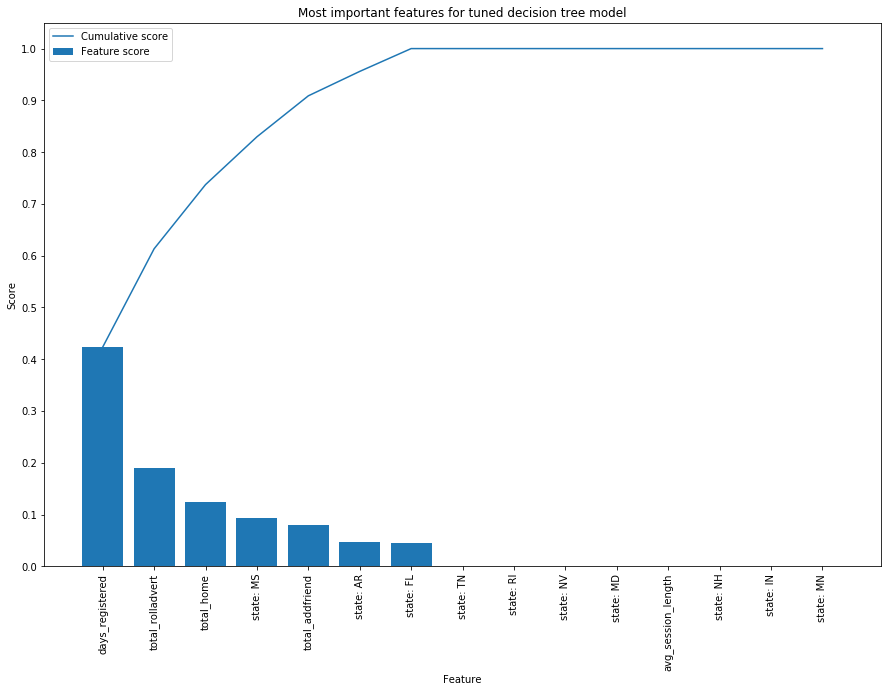

In [87]:
# plot feature score and cumulative score for most important features for tuned decision tree model
# keep only top 15 most important features for plotting
df_feat_imp_dt_15 = df_feat_imp_dt.head(15)

ind = np.arange(len(df_feat_imp_dt_15['name']))

fig = plt.figure(figsize = (15,10))
plt.bar(ind, df_feat_imp_dt_15['score'], label='Feature score')
plt.plot(ind, df_feat_imp_dt_15['cumulative_score'], label='Cumulative score')
plt.title('Most important features for tuned decision tree model')
plt.legend(loc='upper left')
plt.ylabel('Score')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xlabel('Feature')
plt.xticks(ind, df_feat_imp_dt_15['name'], rotation=90)
plt.show()

The above plot indicates the top-15 factors which are most important in predicting churn.  The coefficient represents the weight of the factor and the higher the score the more important the factor.  

The most important factors are the number of days a customer has been registered to the service, and the advertisements she/he has been exposed to.  Together both of these factors explain more than half of the churn prediction.  And, top-5 factors account for nearly 80% of the predictive power.  

In business situations, where resources are at a premium focusing on fewer areas to have the maximum impact is desirable.

As next steps to improve, there are certain areas to look at:
- examine the bigger dataset
- try to reduce the input features


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.